In [1]:
import pandas as pd
from scipy.stats import ttest_rel
# import seaborn as sns
import matplotlib.pyplot as plt

# CSVファイルを読み込み
data_before = pd.read_csv('./after_KD.csv')
data_after = pd.read_csv('./after_EnD.csv')

# 正解ラベルの予測確率の列を抽出
probs_before = data_before['correct_class_prob']
probs_after = data_after['correct_class_prob']

# 対応のあるt検定を実行
t_stat, p_value = ttest_rel(probs_after, probs_before, nan_policy='propagate', alternative='two-sided')

# 結果の表示
print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("知識蒸留前後で統計的に有意な差があります（p < 0.05）")
else:
    print("知識蒸留前後で統計的に有意な差はありません（p >= 0.05）")


t-statistic: 0.5309619320153546, p-value: 0.5954477147781746
知識蒸留前後で統計的に有意な差はありません（p >= 0.05）


In [2]:
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

# CSVファイルの読み込み
data_before = pd.read_csv('./after_KD.csv')
data_after = pd.read_csv('./after_EnD.csv')

# 各サンプルの正解/不正解情報をバイナリ化
correct_before = []
correct_after = []

# 知識蒸留前のモデル
for i in range(len(data_before)):
    if data_before["true_label"][i] == data_before["predicted_label"][i]:
        correct_before.append(1)  # 正解
    else:
        correct_before.append(0)  # 不正解

print(correct_before.count(1))

# 知識蒸留後のモデル
for i in range(len(data_after)):
    if data_after["true_label"][i] == data_after["predicted_label"][i]:
        correct_after.append(1)  # 正解
    else:
        correct_after.append(0)  # 不正解

print(correct_after.count(1))

# 2x2一致表の作成
A = sum((cb == 1 and ca == 1) for cb, ca in zip(correct_before, correct_after))  # 両モデルが正解
B = sum((cb == 1 and ca == 0) for cb, ca in zip(correct_before, correct_after))  # 前モデルのみ正解
C = sum((cb == 0 and ca == 1) for cb, ca in zip(correct_before, correct_after))  # 後モデルのみ正解
D = sum((cb == 0 and ca == 0) for cb, ca in zip(correct_before, correct_after))  # 両モデルが不正解

# 2x2の一致表
table = [[A, B], [C, D]]

# マクネマー検定の実行
result = mcnemar(table, exact=True)  # exact=Trueで正確なp値を計算
print(f"Chi-squared: {result.statistic}, p-value: {result.pvalue}")

# 結果の解釈
if result.pvalue < 0.05:
    print("知識蒸留前後で予測の正解率に統計的に有意な差があります（p < 0.05）")
else:
    print("知識蒸留前後で予測の正解率に統計的に有意な差はありません（p >= 0.05）")


45172
45180
Chi-squared: 379.0, p-value: 0.80034975985733
知識蒸留前後で予測の正解率に統計的に有意な差はありません（p >= 0.05）


/tmp/ipykernel_36422/4065787460.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


KeyboardInterrupt: 

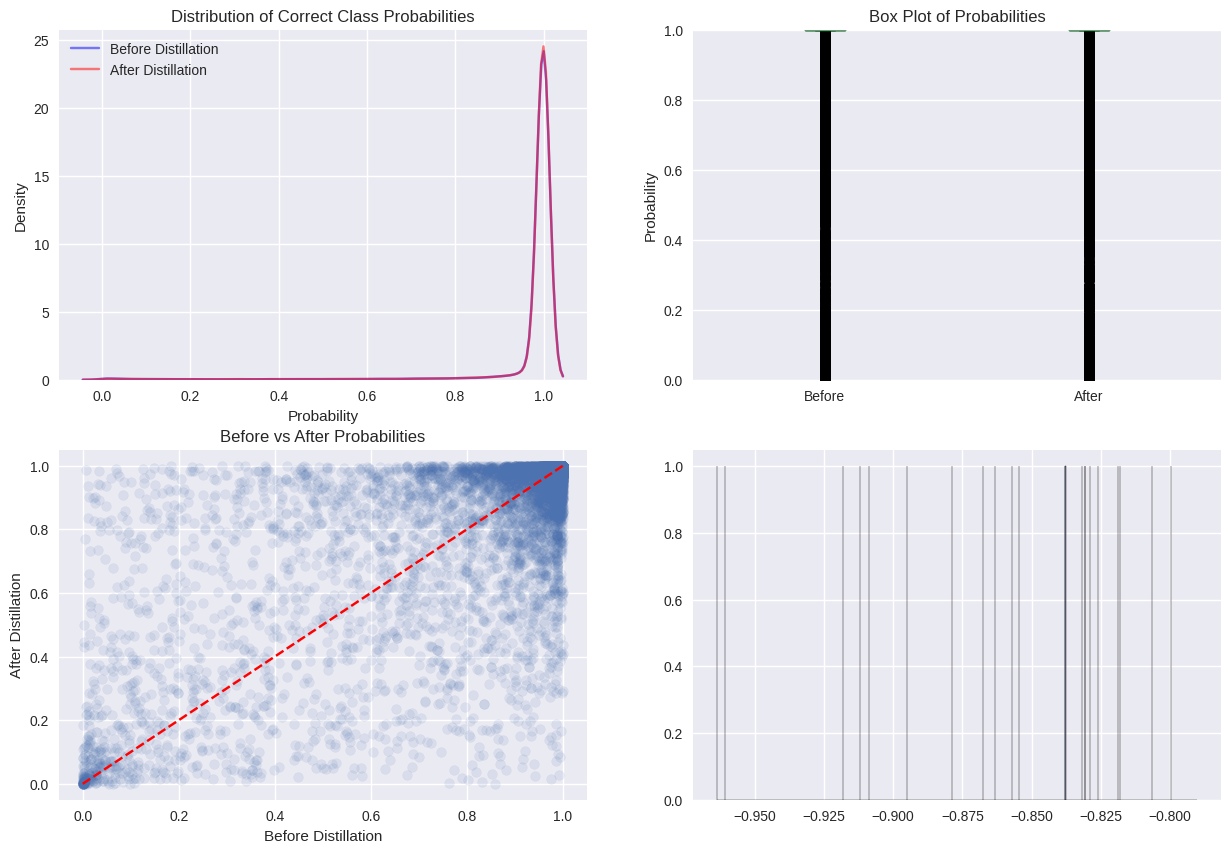

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Figure size and style settings
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))

# 1. Probability distributions comparison (KDE plot)
plt.subplot(2, 2, 1)
sns.kdeplot(data=probs_before, label='Before Distillation', color='blue', alpha=0.5)
sns.kdeplot(data=probs_after, label='After Distillation', color='red', alpha=0.5)
plt.title('Distribution of Correct Class Probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

# 2. Box plot comparison
plt.subplot(2, 2, 2)
plt.ylim(0, 1)  # 確率範囲を0から1に限定
box_data = [probs_before, probs_after]
plt.boxplot(box_data, labels=['Before', 'After'])
plt.title('Box Plot of Probabilities')
plt.ylabel('Probability')

# 3. Scatter plot of Before vs After
plt.subplot(2, 2, 3)
plt.scatter(probs_before, probs_after, alpha=0.1)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('Before Distillation')
plt.ylabel('After Distillation')
plt.title('Before vs After Probabilities')

# 4. Difference distribution with t-test results
plt.subplot(2, 2, 4)
differences = probs_after - probs_before
sns.histplot(differences, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title(f't-stat: {t_stat:.2f}\np-value: {p_value:.2e}\nCohen\'s d: {cohens_d:.3f}')
plt.xlabel('Difference (After - Before)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Optional: Additional visualization for effect size interpretation
plt.figure(figsize=(10, 6))
effect_sizes = [0, 0.2, 0.5, 0.8]
effect_labels = ['No effect', 'Small', 'Medium', 'Large']
plt.plot(effect_sizes, [1]*len(effect_sizes), 'ko', markersize=10)
plt.plot([cohens_d], [1], 'ro', markersize=15, label='Your Effect Size')
plt.axvline(x=cohens_d, color='r', linestyle='--', alpha=0.5)

for size, label in zip(effect_sizes, effect_labels):
    plt.annotate(label, (size, 1.1))

plt.title("Effect Size Interpretation")
plt.xlabel("Cohen's d")
plt.ylim(0.5, 1.5)
plt.legend()
plt.show()

In [7]:
import numpy as np

# 差の標準偏差を計算
diff = probs_after - probs_before
std_diff = np.std(diff, ddof=1)

# 効果量 (Cohen's d) の計算
cohens_d = (probs_after.mean() - probs_before.mean()) / std_diff
print(f"Cohen's d: {cohens_d}")

#---------同じ結果が得られます--------------------------------------

# # 対応のあるサンプルのCohen's dの計算（修正版）
# def cohens_d_paired(x1, x2):
#     # 差分を計算
#     d = x1 - x2
#     # 差分の平均
#     d_mean = d.mean()
#     # 差分の標準偏差
#     d_std = d.std(ddof=1)
#     # Cohen's d
#     d_cohen = d_mean / d_std
#     return d_cohen

# # 計算実行
# d = cohens_d_paired(probs_after, probs_before)
# print(f"Cohen's d: {cohens_d}")


Cohen's d: 0.00247173017641314


In [24]:
# 基本統計量の確認
print("Before distillation:")
print(f"Mean: {probs_before.mean():.4f}")
print(f"Std: {probs_before.std():.4f}")
print("\nAfter distillation:")
print(f"Mean: {probs_after.mean():.4f}")
print(f"Std: {probs_after.std():.4f}")

# 実際の差の大きさ
print(f"\nAbsolute difference in means: {abs(probs_after.mean() - probs_before.mean()):.4f}")

Before distillation:
Mean: 0.9568
Std: 0.1427

After distillation:
Mean: 0.9719
Std: 0.1242

Absolute difference in means: 0.0150


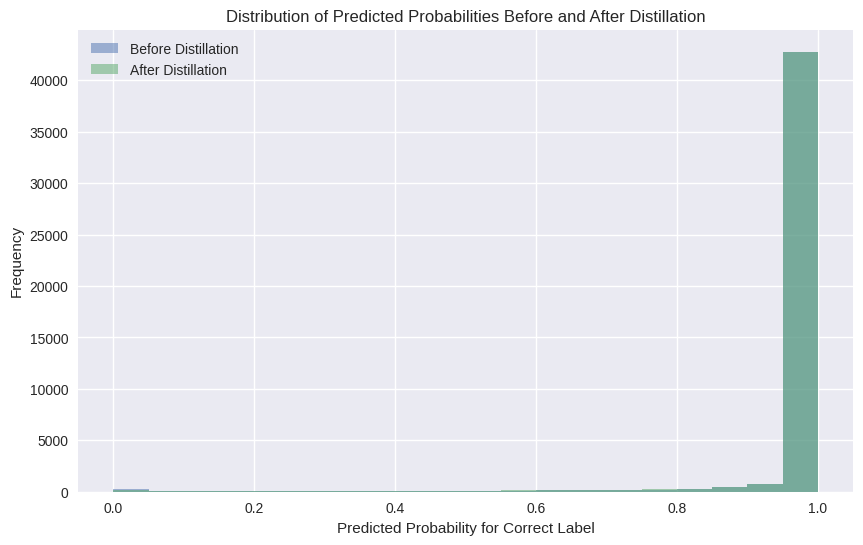

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(probs_before, bins=20, alpha=0.5, label='Before Distillation')
plt.hist(probs_after, bins=20, alpha=0.5, label='After Distillation')
plt.xlabel('Predicted Probability for Correct Label')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities Before and After Distillation')
plt.legend()
plt.show()

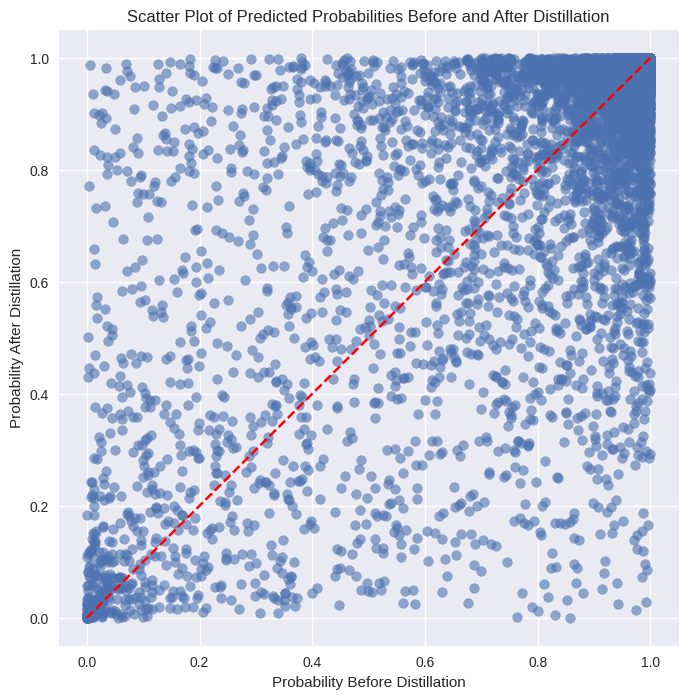

In [6]:
#-----------beforeのそれぞれのデータサンプルにおける確率-------------
probs_before_environ = data_before['correct_class_prob']
probs_before_talk = data_before['correct_class_prob']
probs_before_walk = data_before['correct_class_prob']
#-----------afterの//----------------------------------------------
probs_after_environ = data_before['correct_class_prob']
probs_after_talk = data_before['correct_class_prob']
probs_after_walk = data_before['correct_class_prob']


# 各クラスの確率を抽出
probs_before_environ = data_before[data_before['true_label'] == '0']['correct_class_prob']
probs_before_talk = data_before[data_before['true_label'] == '1']['correct_class_prob']
probs_before_walk = data_before[data_before['true_label'] == '2']['correct_class_prob']

probs_after_environ = data_after[data_after['true_label'] == '0']['correct_class_prob']
probs_after_talk = data_after[data_after['true_label'] == '1']['correct_class_prob']
probs_after_walk = data_after[data_after['true_label'] == '2']['correct_class_prob']


plt.figure(figsize=(8, 8))
plt.scatter(probs_before, probs_after, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')  # 対角線
plt.xlabel('Probability Before Distillation')
plt.ylabel('Probability After Distillation')
plt.title('Scatter Plot of Predicted Probabilities Before and After Distillation')
plt.show()
